## Semantic Relations with BERT Features

In this project we will analyze BBC News Dataset, Extract BERT Embeddings from it, Train a classification model and Find related posts for a given post. Also we demonstrate search capabilites.

In [1]:
import warnings
warnings.filterwarnings("ignore")

### Data Loading and BERT Feature Extracting
We will use ALBert base model for feature inference. Data is preprocessed and needed functions are created for preprocessing and inferring Features.

In [ ]:
!pip install transformers

In [2]:
from transformers import AutoTokenizer, AlbertModel
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')
modelN = AlbertModel.from_pretrained("albert-base-v2")

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/bbc_news.csv")

In [4]:
df.head(2)

,id,article,summary,cat
0,0,Ad sales boost Time Warner profit\n\nQuarterly...,TimeWarner said fourth quarter sales rose 2% t...,business
1,1,Dollar gains on Greenspan speech\n\nThe dollar...,The dollar has hit its highest level against t...,business


In [5]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
modelN = modelN.cuda()

In [7]:
import torch
def features(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    encoded_input = encoded_input.to('cuda')
    output = modelN(**encoded_input)
    return output.pooler_output

def parFeatures(sentences):
    f = []
    for s in sentences:
        s = s.strip("\n")
        f.append(features(s).detach().to('cpu'))
    return torch.cat(f)

In [8]:
def tokenizeArticle(article):
    sents = sent_tokenize(article)
    x = sents[0].split("\n\n")
    x[0] = x[0] + "."
    sents = x + sents[1:]
    sents = map(lambda x: x.strip("\n"), sents)
    sents = list(sents)
    return sents

In [9]:
df["tokens"] = df.article.apply(tokenizeArticle)

In [10]:
df.head(3)

,id,article,summary,cat,tokens
0,0,Ad sales boost Time Warner profit\n\nQuarterly...,TimeWarner said fourth quarter sales rose 2% t...,business,"[Ad sales boost Time Warner profit., Quarterly..."
1,1,Dollar gains on Greenspan speech\n\nThe dollar...,The dollar has hit its highest level against t...,business,"[Dollar gains on Greenspan speech., The dollar..."
2,2,Yukos unit buyer faces loan claim\n\nThe owner...,Yukos' owner Menatep Group says it will ask Ro...,business,"[Yukos unit buyer faces loan claim., The owner..."


In [11]:
from tqdm import tqdm

In [18]:
feat = {}
c = 0
for i in tqdm(range(len(df.tokens))):
    try:
        feat[i] = parFeatures(df.tokens.iloc[i])
    except:
        feat[i] = 0
        c += 1
print("error count in bert embeddings: ", c)

100%|██████████| 2225/2225 [09:02<00:00,  4.10it/s]

error count in bert embeddings:  1


#### Utility for saving the embeddings as inferring features for whole data takes time 

In [ ]:
import joblib
joblib.dump(feat,"bbc-token-features.data")

In [13]:
import joblib
feat = joblib.load("/content/drive/MyDrive/bbc-token-features.data")

#### Prepare input tensors

In [14]:
t = list(feat.keys())
t.sort()
keyList = list(filter(lambda x: type(feat[x]) == torch.Tensor, t))
r = list(map(lambda c: feat[c], keyList))

In [15]:
X_s = torch.cat(r)

In [16]:
X = torch.cat(list(map(lambda x: x.mean(axis=0).reshape(1, -1), r)))

In [17]:
# Tensor of pooled articles
X.shape

torch.Size([2224, 768])

In [18]:
# Tensor of article sentences
X_s.shape

torch.Size([43641, 768])

In [19]:
# Dataframe for articles
ndf = df.iloc[keyList]
# Dataframe for sentences
sdf = ndf.explode('tokens')[["id", "tokens", "cat"]]

#### Model Training Utilities

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from torchvision import datasets, transforms

In [21]:
import torch
class GlobalManager:
    def __init__(self, use_gpu=False, log_state=False):
        self.use_gpu = use_gpu
        self.log_state = log_state
        self.cpu_d = torch.device("cpu")
        self.device = torch.device("cuda") if use_gpu else self.cpu
        pass

    def is_gpu(self):
        return self.use_gpu
    
    def current(self):
        return self.device

    def cpu(self):
        return self.cpu_d
    
    def log(self, msg):
        if self.log_state:
            print(msg)

In [22]:
class ExecutionEvents:
    def __init__(self):
        pass

    def set_model(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer

    def on_epoch_start(self, epoch, **kwargs):
        if hasattr(self, 'es'):
            self.es(epoch, **kwargs)
        pass
    
    def on_epoch_end(self, epoch, losses, avg_loss, **kwargs):
        if hasattr(self, 'ee'):
            self.ee(epoch, losses, avg_loss, **kwargs)
        pass

    def on_batch_processed(self, epoch, batch, loss, **kwargs):
        if hasattr(self, 'bp'):
            self.bp(epoch, batch, loss, **kwargs)
        pass

    def on_validated(self, epoch, loss, **kwargs):
        if hasattr(self, 'v'):
            self.v(epoch, loss, **kwargs)
        pass

    def attach_epoch_start(self, func):
        self.es = func
        pass
    
    def attach_epoch_end(self, func):
        self.ee = func
        pass

    def attach_batch_processed(self, func):
        self.bp = func
        pass

    def attach_validated(self, func):
        self.v = func
        pass
    

In [23]:
class PreprocessingDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [24]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [25]:
from tqdm import tqdm
import torch.nn
import torch
from torch.utils.data import DataLoader, random_split

class Executor:
    def __init__(self, model, manager):
        self.model = model.to(manager.current())
        self.manager = manager
    
    def configure(self, optimizer, loss="cross_entropy", preprocessor=None):
        self.optimizer = optimizer
        if isinstance(loss, str):
            if loss == "mse":
                self.criterion = F.mse_loss
            elif loss == "cross_entropy":
                self.criterion = F.cross_entropy
            else:
                raise Exception("Undefined loss func, use function or nn.Module instead!")
        elif isinstance(loss, nn.Module) or type(loss).__name__ == "function":
            self.criterion = loss
        else:
            raise Exception("loss parameter must be string, function or nn.Module!")
        
        if preprocessor is None:
            self.preproc = False
            pass
        elif type(preprocessor).__name__ == "function":
            self.preproc = True
            self.preprocessor = preprocessor
        else:
            raise Exception("Preprocessor type not recognized!")

    def train(self, train_dataset, epochs, val_split=0.15, train_batch=32, val_batch=32,
              event_listener=None, progress=True, metrics={},
              early_stopping=False, patience=5):
        total = len(train_dataset)
        val_count = int(val_split * total)
        self.train_set, self.val_set = random_split(train_dataset, (total - val_count, val_count))

        train_loader = DataLoader(self.train_set, batch_size=train_batch, shuffle=True)
        val_loader = DataLoader(self.val_set, batch_size=val_batch, shuffle=True)

        if self.preproc:
            train_loader = PreprocessingDataLoader(train_loader, self.preprocessor)
            val_loader = PreprocessingDataLoader(val_loader, self.preprocessor)
        event_listener = ExecutionEvents() if event_listener is None else event_listener
        event_listener.set_model(self.model, self.optimizer)
        if early_stopping:
            self.es = EarlyStopping(patience=patience)
        for i in range(epochs):
            #Training an epoch
            model.train()
            losses = {}
            metrics_v = {}
            for metric in metrics:
                metrics_v[metric] = {}
            it = enumerate(train_loader)
            it = tqdm(it, total=len(train_loader), position=0) if progress else it
            if progress:
                it.set_description('Epoch %d' % i)
            event_listener.on_epoch_start(i)
            for batch_idx, (data, target) in it:
                data, target = data.to(self.manager.current()), target.to(self.manager.current())
                def fwd():
                    self.optimizer.zero_grad()
                    output = self.model(data)
                    loss = self.criterion(output, target)
                    losses[batch_idx] = loss.item()
                    for metric in metrics:
                        metrics_v[metric][batch_idx] = metrics[metric](output, target).item()
                    loss.backward(create_graph=True)
                    return loss, output
                self.optimizer.step(closure=fwd)
                event_listener.on_batch_processed(i, batch_idx, losses[batch_idx])
                if progress:
                    m_mean = {k: np.mean(list(metrics_v[k].values())) for k in metrics}
                    it.set_postfix(batch=batch_idx, loss=losses[batch_idx], mean_loss=np.mean(list(losses.values())),
                                  **m_mean)
            if progress:
                it.close()
            ls = list(losses.values())
            m_mean = {k: np.mean(list(metrics_v[k].values())) for k in metrics}
            m_all = {k+"_all": list(metrics_v[k].values()) for k in metrics}
            event_listener.on_epoch_end(i, ls, np.mean(ls), **m_mean, **m_all)
            #Validating an epoch
            model.eval()

            it = val_loader
            it = tqdm(it, total=len(val_loader), position=0) if progress else it
            if progress:
                it.set_description('Validating Epoch %d' % i)

            loss_val = []
            metrics_val = {}
            for metric in metrics:
                metrics_val[metric] = []
            with torch.no_grad():
                for data, target in it:
                    data, target = data.to(self.manager.current()), target.to(self.manager.current())
                    output = self.model(data)
                    loss = self.criterion(output, target)
                    loss = loss.item()
                    loss_val.append(loss)
                    for metric in metrics:
                        metrics_val[metric].append(metrics[metric](output, target).item())
                    if progress:
                        m_mean = {k: np.mean(metrics_val[k]) for k in metrics}
                        it.set_postfix(loss=loss, mean_loss=np.mean(loss_val),
                                    **m_mean)
            m_mean = {k: np.mean(metrics_val[k]) for k in metrics}
            m_all = {k+"_all": metrics_val[k] for k in metrics}
            event_listener.on_validated(i, np.mean(loss_val), **m_mean, **m_all)
            if early_stopping:
                if self.es.step(torch.tensor(np.mean(loss_val))):
                    break
            if progress:
                it.close()
    def eval(self, test_dataset, batch_size=32, progress=True, metrics={}):
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        if self.preproc:
            test_loader = PreprocessingDataLoader(test_loader, self.preprocessor)

        model.eval()

        it = test_loader
        it = tqdm(it, total=len(test_loader), position=0) if progress else it
        if progress:
            it.set_description("Evaluating")

        loss_val = []
        metrics_val = {}
        for metric in metrics:
            metrics_val[metric] = []
        outs = []
        with torch.no_grad():
            for data, target in it:
                data, target = data.to(self.manager.current()), target.to(self.manager.current())
                output = self.model(data)
                outs.append(output)
                loss = self.criterion(output, target).item()
                loss_val.append(loss)
                for metric in metrics:
                    metrics_val[metric].append(metrics[metric](output, target).item())
                if progress:
                    m_mean = {k: np.mean(metrics_val[k]) for k in metrics}
                    it.set_postfix(loss=loss, mean_loss=np.mean(loss_val),
                                **m_mean)
        m_mean = {k: np.mean(metrics_val[k]) for k in metrics}
        m_mean["loss"] = np.mean(loss_val)
        if progress:
            it.close()
        return torch.cat(outs), m_mean

In [26]:
def accuracy(pred, gt):
    pred = pred.argmax(dim=1, keepdim=True)
    correct = pred.eq(gt.view_as(pred)).sum()
    return correct.float()/pred.shape[0]

def loss(predicted, ground_truth):
    return F.nll_loss(predicted, ground_truth)

def loss_n(model, lambda_):
    def loss(predicted, ground_truth):
        return F.nll_loss(predicted, ground_truth)
    return loss

In [27]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [28]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

### Neural Network Design and Training for Classification

In [29]:
class CatNet(nn.Module):
    def __init__(self, dropout=False):
        super(CatNet, self).__init__()

        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 5)

        self.dropout = dropout
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.1)
        self.softmax = nn.LogSoftmax()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        if self.dropout:
            x = self.dropout1(x)
        x = self.fc2(x)
        if self.dropout:
            x = self.dropout2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [30]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

ndf["catn"] = enc.fit_transform(ndf.cat)
sdf["catn"] = enc.fit_transform(sdf.cat)

In [31]:
from sklearn.model_selection import train_test_split

# y = torch.tensor(ndf.catn.to_numpy())
y = torch.tensor(sdf.catn.to_numpy())
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2)

In [32]:
from torch.utils.data import Dataset

class EasyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.X[idx], self.y[idx]

In [33]:
# Load Previous State
model = CatNet(dropout=True)
model.load_state_dict(torch.load("catnet.bin")())
model = model.cuda()

data = joblib.load("train-state.data")

In [39]:
import torch.optim as optim

data = {
    "losses": [],
    "val_losses":[],
    "acc":[],
    "val_acc":[],
}

model = CatNet(dropout=True)
train_set = EasyDataset(X_train, y_train)
test_set = EasyDataset(X_test, y_test)
executor = Executor(model, GlobalManager(use_gpu=True, log_state=True))
optimizer = optim.Adam(model.parameters(), lr=0.001)
executor.configure(optimizer, loss_n(model, 0), preprocessor=None)
listener = ExecutionEvents()

def vd(ep, loss, **kw):
    data["val_losses"].append(loss)
    data["val_acc"].append(kw["acc_all"])

def ee(ep, loss, avg, **kw):
    data["losses"].append(loss)
    data["acc"].append(kw["acc_all"])

listener.attach_validated(vd)
listener.attach_epoch_end(ee)

executor.train(train_set, 150, train_batch=48, val_batch=64,
                early_stopping=True, patience=12,
                event_listener=listener, metrics={"acc":accuracy})

res, data["info"] = executor.eval(test_set, batch_size=64, metrics={"acc":accuracy})

Evaluating: 100%|██████████| 137/137 [00:00<00:00, 225.98it/s, acc=0.784, loss=0.472, mean_loss=0.591]


In [ ]:
#Save State
torch.save(model.state_dict, "catnet.bin")
joblib.dump(data, "train-state.data")

In [34]:
def theme(figure, axList):
    for ax in axList:
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(colors='white', which='both')
        ax.set_facecolor("#0e101f")
        plt.setp(ax.get_title(), color='white')
        legend = ax.get_legend()
        if legend:
            frame = legend.get_frame()
            if frame:
                frame.set_facecolor('#202446')
                frame.set_edgecolor('#2D3262')
            for text in legend.get_texts():
                text.set_color("white")
    figure.set_facecolor("#0e101f")

In [35]:
import matplotlib.pyplot as plt

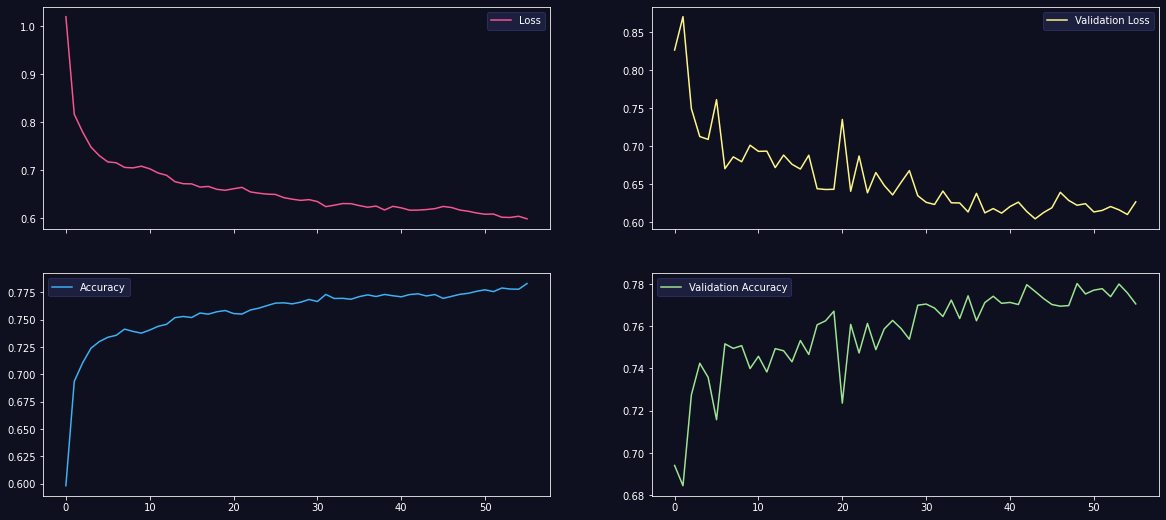

In [36]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(20, 9))

axs[0, 0].plot(torch.tensor(data["losses"]).mean(axis=1), color="#F75590", label="Loss")
axs[0, 0].legend(loc="upper right")
axs[0, 1].plot(torch.tensor(data["val_losses"]), color="#FFF689", label="Validation Loss")
axs[0, 1].legend(loc="upper right")
axs[1, 0].plot(torch.tensor(data["acc"]).mean(axis=1), color="#3DB1F5", label="Accuracy")
axs[1, 0].legend(loc="upper left")
axs[1, 1].plot(torch.tensor(data["val_acc"]).mean(axis=1), color="#9EE493", label="Validation Accuracy")
axs[1, 1].legend(loc="upper left")

theme(fig, [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]])

In [37]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [38]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6145033795394661

#### Model Inference

In [39]:
def inferFeatures(text):
    s = sent_tokenize(text)
    xr = parFeatures(s)
    return xr.mean(axis=0)

In [40]:
def predictDT(text):
    f = inferFeatures(text)
    pred = clf.predict(f.unsqueeze(dim=0)) 
    return enc.inverse_transform(pred)[0]

In [41]:
def predictClass(text):
    f = inferFeatures(text)
    pred = model(f.unsqueeze(dim=0).to('cuda')) 
    cl = pred.argmax(dim=1, keepdim=True)[0]
    return enc.inverse_transform(cl.cpu())[0]

In [44]:
text1 = """What McDonald’s minimum wage raise says about fast-food franchise future.
McDonald’s is among fast-food franchises to raise wages in a tight labor market and plans to reach an average of $15 an hour by 2024 at all company-owned restaurants.
Competition for workers is intense and food franchises like McDonald’s and Chipotle are competing with retailers like Amazon, Walmart and Target, McDonald’s CEO Chris Kempczinski noted in a recent CNBC Evolve interview.
"""
print("Neural Net:", predictClass(text1))
print("Decision Tree:", predictClass(text1))

Neural Net: business
Decision Tree: business


In [45]:
text2 = """Biden presses Putin to disrupt cybercriminals in Russia as U.S. grapples with latest ransomware attacks.
President Joe Biden pressed Russian President Vladimir Putin in a phone call Friday to take action to stem recent ransomware attacks from Russia-based groups.
The call came just days after a massive new cyberattack by the group REvil, believed to be based in Russia.
"""
print("Neural Net:", predictClass(text2))
print("Decision Tree:", predictClass(text2))

Neural Net: politics
Decision Tree: business


In [46]:
text3 = """
Biden fires Social Security Commissioner Andrew Saul, who says he isn't leaving.
Saul was one of the few remaining federal appointees from former President Donald Trump’s administration.
President Biden fired Social Security Commissioner Andrew Saul on Friday amid an ongoing dispute over his leadership of the independent agency responsible for administering retirement and disability benefits.
"""
print("Neural Net:", predictClass(text3))
print("Decision Tree:", predictClass(text3))

Neural Net: politics
Decision Tree: politics


In [47]:
text4 = """U.S. military mission in Afghanistan will end by August 31, Biden says.
President Joe Biden says the 20-year U.S. military mission in Afghanistan will end by August 31.
“We did not go to Afghanistan to nation build,” Biden says.
“It’s up to the Afghans to make decisions about the future of their country,” says Biden, who announced in April the planned departure of U.S. forces.
"""
print("Neural Net:", predictClass(text4))
print("Decision Tree:", predictClass(text4))

Neural Net: politics
Decision Tree: politics


In [48]:
text5 = """
To home or Rome? England takes on Italy to end title drought.
"Maybe at 36 you feel it more," Chiellini said, "because you understand more how hard it is and the work that goes into it."

The European Championship final on Sunday pits England, which hasn’t even reached a final since winning the 1966 World Cup, against one of the continent’s most decorated teams.

The last of Italy’s four World Cup victories came in 2006, when Chiellini had already made his international debut but didn’t play at the tournament. But the team is a comparative underachiever in the European Championship with its only title in 1968.

"""
print("Neural Net:", predictClass(text5))
print("Decision Tree:", predictClass(text5))

Neural Net: sport
Decision Tree: sport


### Find k-Near Related Posts

In [49]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [50]:
d , idx = neigh.kneighbors(X[0].unsqueeze(dim=0), 5, return_distance=True)

In [51]:
ndf.iloc[idx[0]]

,id,article,summary,cat,tokens,catn
0,0,Ad sales boost Time Warner profit\n\nQuarterly...,TimeWarner said fourth quarter sales rose 2% t...,business,"[Ad sales boost Time Warner profit., Quarterly...",0
232,232,Krispy Kreme shares hit\n\nShares in Krispy Kr...,Shares in Krispy Kreme Doughnuts have taken a ...,business,"[Krispy Kreme shares hit., Shares in Krispy Kr...",0
269,269,Nortel in $300m profit revision\n\nTelecoms eq...,"""With the completion of our restatements we ha...",business,"[Nortel in $300m profit revision., Telecoms eq...",0
147,147,"Dutch bank to lay off 2,850 staff\n\nABN Amro,...","ABN Amro, the Netherlands' largest bank, is to...",business,"[Dutch bank to lay off 2,850 staff., ABN Amro,...",0
160,160,Strong quarterly growth for Nike\n\nNike has r...,That is 9.1% higher than such orders reported ...,business,"[Strong quarterly growth for Nike., Nike has r...",0


In [52]:
def kNearPosts(text, k=5):
    Q = inferFeatures(text)
    d , idx = neigh.kneighbors(Q.unsqueeze(dim=0), k, return_distance=True)
    return ndf.iloc[idx[0]]

In [53]:
kNearPosts("Stocks market bullish trend")

,id,article,summary,cat,tokens,catn
102,102,Cars pull down US retail figures\n\nUS retail ...,"Excluding the car sector, US retail sales were...",business,"[Cars pull down US retail figures., US retail ...",0
1820,1820,Almagro continues Spanish surge\n\nUnseeded Ni...,"Nadal, playing in the outdoor clay event for t...",sport,"[Almagro continues Spanish surge., Unseeded Ni...",3
444,444,Ericsson sees earnings improve\n\nTelecoms equ...,"For the whole of 2004, Ericsson returned a net...",business,"[Ericsson sees earnings improve., Telecoms equ...",0
92,92,Asian quake hits European shares\n\nShares in ...,The unfolding scale of the disaster in south A...,business,"[Asian quake hits European shares., Shares in ...",0
1531,1531,Yeading face Newcastle in FA Cup\n\nPremiershi...,Premiership side Newcastle United face a trip ...,sport,"[Yeading face Newcastle in FA Cup., Premiershi...",3


In [54]:
kNearPosts("Afghanistan War and Terrorism Activities in It")

,id,article,summary,cat,tokens,catn
204,204,Soros group warns of Kazakh close\n\nThe Open ...,"The Open Society Institute (OSI), financed by ...",business,"[Soros group warns of Kazakh close., The Open ...",0
1036,1036,UK troops on Ivory Coast standby\n\nDowning St...,Downing Street has confirmed British troops ar...,politics,"[UK troops on Ivory Coast standby., Downing St...",2
1111,1111,February poll claim 'speculation'\n\nReports t...,A British general election was last held in Fe...,politics,"[February poll claim 'speculation'., Reports t...",2
913,913,Straw to attend Auschwitz service\n\nForeign S...,Shadow Foreign Secretary Michael Ancram said: ...,politics,"[Straw to attend Auschwitz service., Foreign S...",2
278,278,Asia quake increases poverty risk\n\nNearly tw...,Nearly two million people across Asia could be...,business,"[Asia quake increases poverty risk., Nearly tw...",0
